# Day 4, Plotting

In [2]:
import matplotlib.pyplot as plt,os,time,matplotlib;import numpy as np; import pandas as pd
im_path=os.sep.join((os.getcwd(),'pictures',''))
def sho(img,figsize=(12,6)):
    fig,ax=plt.subplots(figsize=figsize)
    img=plt.imread(img)
    ax.imshow(img)
    ax.axis('off')
%matplotlib inline

## Homework

We have a reaction A-> B  with the first order rate constant $6∙10^{-4}$Mol/s.

Read in the spectra A.csv and B.csv from the data folder and make a nice plot (with all labels)
As Inset make a inset (small figure in figure) on the region around 298 nm

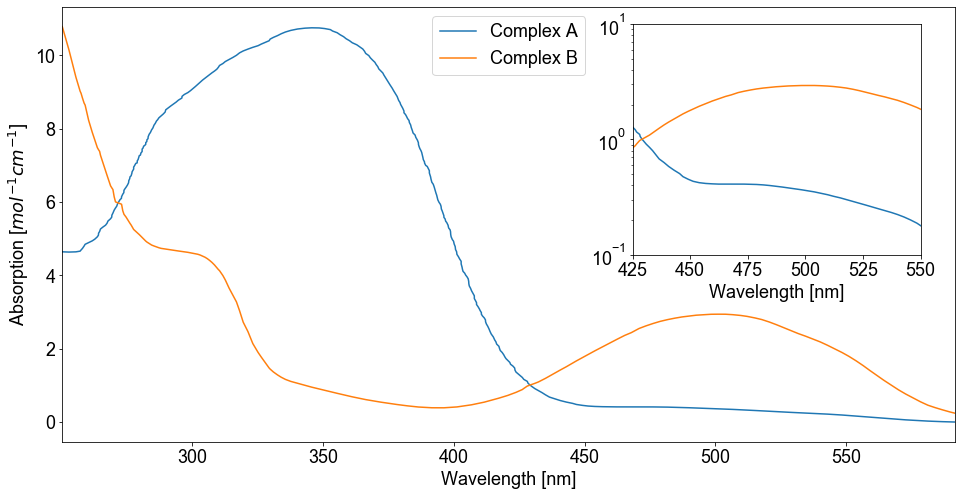

In [3]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 18}
matplotlib.rc('font', **font)
from scipy.interpolate import interp1d

data=pd.read_csv(os.sep.join(['data','Iron_carbene_4_3.csv']),sep=';',index_col=0)
data.index.name='Wavelength [nm]'
fig,ax=plt.subplots(figsize=(16,8))
inset=fig.add_axes([0.62,0.45,0.25,0.4])
data.plot(ax=ax)
ax.legend(loc=9)
data.plot(ax=inset,legend=None)
inset.set_xlim(425,550)
inset.set_ylim(0.1,10)
ax.set_ylabel(r'Absorption [$mol^{-1}cm^{-1}$]')
inset.set_yscale('log')

#### original data import and cleaning

In [4]:
if 0:
    a=pd.read_csv(os.sep.join(['data','CabChamp_0.csv']),sep=',',index_col=0,header=None)
    b=pd.read_csv(os.sep.join(['data','CabChamp_1.csv']),sep=',',index_col=0,header=None)
    def savitzky_golay(y, window_size, order, deriv=0, rate=1):
        import numpy as np
        from math import factorial
        order_range = range(order+1)
        half_window = (window_size -1) // 2
        b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
        m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
        firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
        lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
        y = np.concatenate((firstvals, y, lastvals))
        return np.convolve( m[::-1], y, mode='valid')
    def Frame_golay(df, window=5, order=2):
        df=df.fillna(0)
        for col in df.columns:#alternative use the "apply function"
            df[col]=savitzky_golay(df[col].values, window, order)
        return df
    a1=Frame_golay(a,15,2)
    b1=Frame_golay(b,3,1)
    dicten={'Complex A original':a.values[:,0],'Complex A':a1.values[:,0],'Complex B original':np.interp(a.index,b.index,b.values[:,0]),'Complex B':np.interp(a.index,b1.index,b1.values[:,0])}
    data=pd.DataFrame(dicten,index=a.index)
    ax=data.plot()
    ax.set_xlim(250,600)
    out_dat=data[['Complex A','Complex B']]
    out_dat=out_dat.loc[250:600]
    #out_dat.to_csv('data'+os.sep+'Iron_carbene_4_3.csv',sep=';')

##### Create vectors or Dataframes that includes the relative concentrations A and B as a function of time. 
You can of course use numerical integration to do this, but we have a simple first order reaction here and maybe using a formula might be easier.
In a new figure plot the concentrations as function of time and fill the curve under the line. (Hint: zorder=0-10) is setting the level at which a plot is made. 

Text(0.5, 0, 'time[s]')

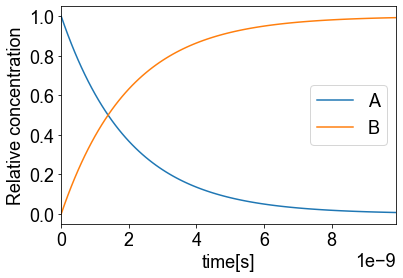

In [5]:
time=np.arange(0,10e-9,100e-12)
C={'A':np.exp(-time/2e-9),'B':1-np.exp(-time/2e-9)}
C=pd.DataFrame(C,index=time)
fig,ax=plt.subplots()
C.plot(ax=ax)
ax.set_ylabel('Relative concentration')
ax.set_xlabel('time[s]')

Use these concentrations as intensities for the measured spectra to make a linear combination with the measured spectrum and create a 3d plot with the projections (like above). So if $A(\lambda)$ is the spectrum from A, $c_A(t)$ the concentration of A at time t. Then the linear combination is:

$\text{Total Spectrum}(t)=c_A(t) * A(\lambda) + c_B(t) * B(\lambda)$ is the spectrum at time t. If you use vectors for the concentrations as function of time you will get a 2d Matrix that contains the spectra as function of time. You can either use matrix multiplication to achieve this or loop through the time points. 

Text(0.5, 0, 'Wavelength [nm]')

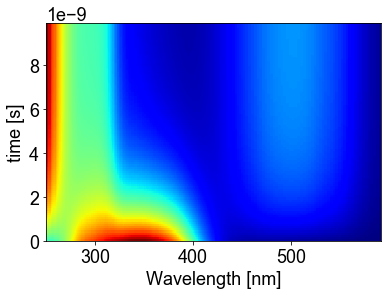

In [6]:
Z=np.matmul(C.values,data.values.T)
X,Y=np.meshgrid(data.index.values,C.index.values)
fig,ax=plt.subplots()
ax.pcolormesh(X,Y,Z,cmap='jet')
ax.set_ylabel('time [s]')
ax.set_xlabel('Wavelength [nm]')

# Nerd Alarm

In [7]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Parameter optimization often called: Fitting

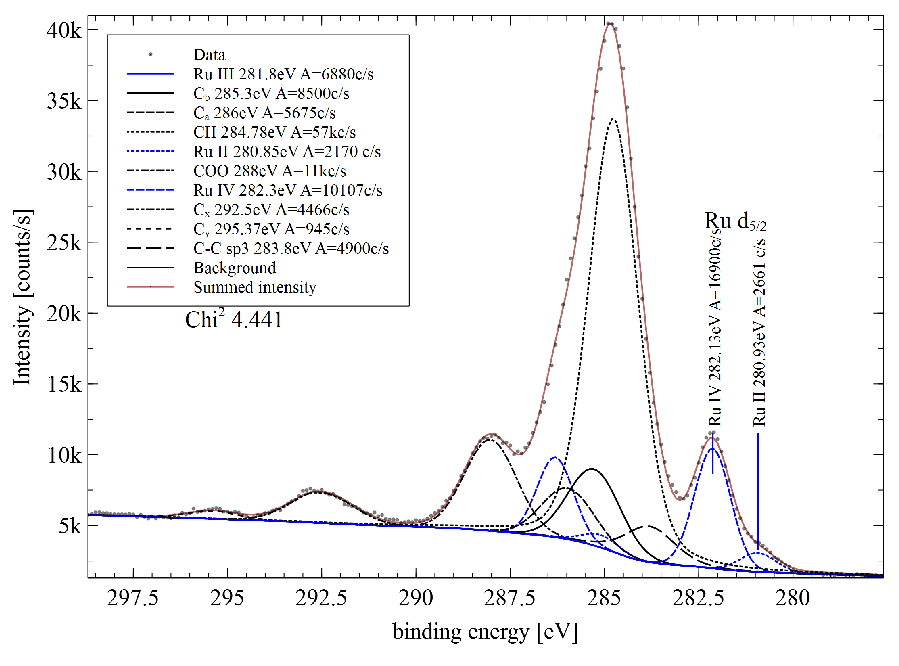

In [8]:
sho(os.sep.join(('pictures','KEMM30_007.png')),figsize=(24,12))

How do you get there? or better,how do you get there without producing a lot of nonsense
Counting parameter. e.g. 10 peaks, each position, width, intensity =30 parameter plus background. So fitting is about intelligence. Think, $\textbf{optimize}$ the smallest amount of parameter starting with a good guess

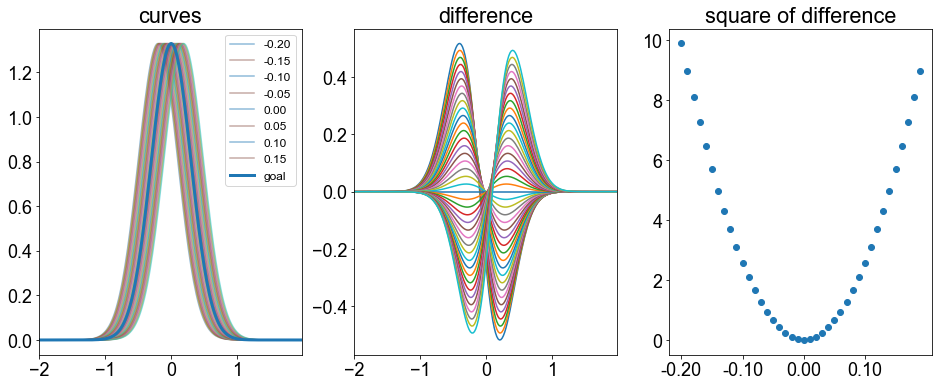

In [9]:
def gauss(x,mu=0.,sigma=1.):
    '''returns a vector that contains the normalized 
    and centered gauss function'''
    pre_factor=1/np.sqrt(2*np.pi*(sigma**2))
    exponent=(-0.5/sigma**2)*(np.subtract(x,mu))**2
    return pre_factor*np.exp(exponent)

x=np.arange(-2,2,0.02)
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(16,6))
out={}
shifts=np.arange(-0.2,0.2,0.01)
for shift in shifts:
    out['%.2f'%shift]=gauss(x,mu=shift,sigma=0.3)
ds=pd.DataFrame(out,index=x)
ds['goal']=pd.Series(gauss(x,mu=0.,sigma=0.3),index=x,name='goal')
ds.iloc[:,:-1].plot(ax=axs[0],alpha=0.5,legend=False)
ds.iloc[:,-1].plot(ax=axs[0],alpha=1,legend=False,lw=3,title='curves')
leg=axs[0].get_legend_handles_labels()
axs[0].legend(leg[0][::5],leg[1][::5],fontsize=12)

diff=(ds.iloc[:,:-1].subtract(ds['goal'],axis=0))
diff.plot(ax=axs[1],legend=False,title='difference')
error=((diff**2).sum(axis='rows'))
axs[2].plot(error.index.values,error.values,'o')
axs[2].set_title('square of difference')

axs[2].set_xticks(axs[2].get_xticks()[::10])


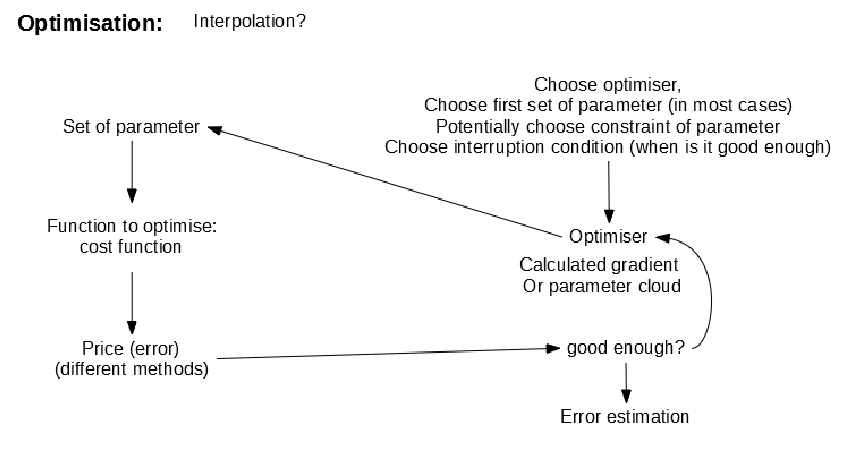

In [13]:
sho(os.sep.join(['pictures','KEMM30_008.jpg']),figsize=(18,8))

,values,errors
$\mu$,0.499539,0.005956
$\sigma$,0.510183,0.004863
$x_0$,0.052727,0.001936


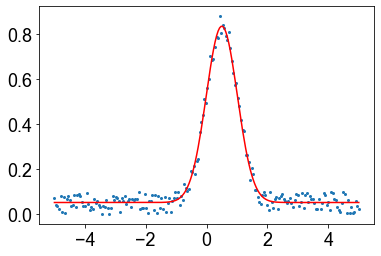

In [10]:
def gauss(x,mu,sigma,offset=0):
    '''returns a vector that contains the normalized 
    and centered gauss function'''
    pre_factor=1/np.sqrt(2*np.pi*(sigma**2))
    exponent=(-0.5/sigma**2)*(np.subtract(x,mu))**2
    return pre_factor*np.exp(exponent)+offset

x=np.linspace(-5,5,200)
y=gauss(x,mu=0.5,sigma=0.5)+0.1*np.random.random(np.shape(x))
fig,ax=plt.subplots()
ax.plot(x,y,'o',ms=2)

from scipy.optimize import curve_fit
popt,pcov = curve_fit(gauss, xdata=x, ydata=y,p0=[1,0.5,0.1])

ax.plot(x, gauss(x, mu=popt[0],sigma=popt[1],offset=popt[2]), 'r-', label='fit')

perr = np.sqrt(np.diag(pcov))
df=pd.DataFrame({'values':popt,'errors':perr},index=['$\mu$','$\sigma$','$x_0$'])
df=df[['values','errors']]
df

The key bit
```
from scipy.optimize import curve_fit
popt,pcov = curve_fit(gauss, xdata=x, ydata=y,p0=[1,0.5,0.1])
```
curve fit is a least square method that takes a function, the target data and a set of starting parameters, that are in order the parameter after the first.
it returns: 
popt = optimized parameter
and
pcov = covariance matrix.
p_sigma = np.sqrt(np.diag(pcov))


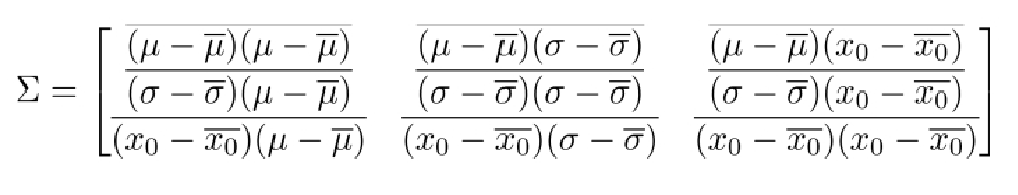

In [14]:
sho(os.sep.join(['pictures','KEMM30_009.jpg']),figsize=(18,8))

In [15]:
pcov

array([[ 3.54766867e-05, -3.67841453e-13, -2.04084957e-15],
       [-3.67841453e-13,  2.36511250e-05, -1.32301946e-13],
       [-2.04084957e-15, -1.32301946e-13,  3.74933219e-06]])

In [11]:
print('optimized parameters are: {}\n'.format(popt))
print('errors of these parameters are: {}\n'.format(np.sqrt(np.diag(pcov))))
import uncertainties.unumpy as unp
res=unp.uarray(popt,np.sqrt(np.diag(pcov)))
print('with uncertainties the parameters read: \n{}\n'.format(res))
df

optimized parameters are: [0.49953938 0.51018257 0.05272722]

errors of these parameters are: [0.00595623 0.00486324 0.00193632]

with uncertainties the parameters read: 
[0.4995393830005227+/-0.005956230911551803
 0.5101825662820608+/-0.004863242231944951
 0.05272721795656778+/-0.0019363192381786703]



,values,errors
$\mu$,0.499539,0.005956
$\sigma$,0.510183,0.004863
$x_0$,0.052727,0.001936


### Tasks:

Fit files and plot both, data and fits:
* fit_0.csv
* fit_1.csv
    here: try first a separate fit, in which you fit the linear range and then separately the peak.
    second fit peak and background simulataneaously
* fit_2.csv (fit line to linear range in addition to data)